In [1]:
import torch

# CUDAが使えるかどうかを確認
cuda_available = torch.cuda.is_available()

if cuda_available:
    print(f"CUDA is available! GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")
     

CUDA is available! GPU: Quadro RTX 5000


# **1枚画像**


image 1/1 C:\Users\ykita\ROP_AI_project\ROP_image\IMG_1699\IMG_1699_0300.jpg: 640x640 1 Lens, 74.4ms
Speed: 7.0ms preprocess, 74.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
0 0.461330 0.440401 0.564847 0.323548


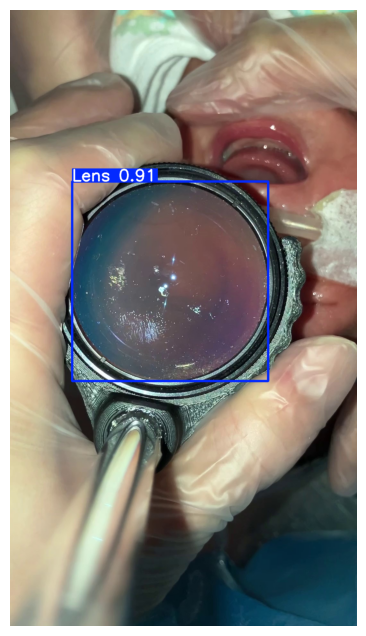

YOLO形式の推論結果をテキストファイルに保存しました: result.txt


In [2]:
from ultralytics import RTDETR
import wget
import cv2
import matplotlib.pyplot as plt

# モデルが未定義ならロードする
model = RTDETR(r"C:\Users\ykita\ROP_AI_project\models\rtdetr-l-1697_1703.pt")
try:
    model  # 変数modelが定義されているか確認
except NameError:
    print("modelが未定義のため、ロードを実行します。")
    model = RTDETR(r"C:\Users\ykita\ROP_AI_project\models\rtdetr-l-1697_1703.pt")

# 推論を実行: YOLOの推論
image_path = r'C:\Users\ykita\ROP_AI_project\ROP_image\IMG_1699\IMG_1699_0300.jpg'
results = model(image_path, save=False)

for r in results:
    boxes = r.boxes  # YOLOv8の場合

    # YOLO形式出力
    for box in boxes:
        cls_id = int(box.cls[0])  # クラスID
        x_center, y_center, width, height = box.xywhn[0]

        # YOLO形式: class x_center y_center width height
        # 小数点以下6桁で出力したい場合
        print(f"{cls_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    # 検出結果を画像に描画して表示
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(r.plot(), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # 結果の保存
    #cv2.imwrite('result.jpg', r.plot())

# YOLO形式の推論結果をresult.txtに保存
save_txt_path = 'result.txt'

# YOLO形式の推論結果をテキストファイルに書き込み
with open(save_txt_path, 'w') as f:
    for r in results:
        boxes = r.boxes  # YOLOv8系の出力
        for box in boxes:
            cls_id = int(box.cls[0])  
            x_center, y_center, width, height = box.xywhn[0]
            # YOLO形式: class x_center y_center width height （小数点以下6桁）
            line = f"{cls_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n"
            f.write(line)

print(f"YOLO形式の推論結果をテキストファイルに保存しました: {save_txt_path}")


## **複数画像**

### merge known bounding box

In [ ]:
import cv2
import os
import numpy as np
from pathlib import Path
from glob import glob

def load_yolo_annotations(annotation_path):
    """YOLOフォーマットのアノテーションを読み込む"""
    boxes = []
    if os.path.exists(annotation_path):
        with open(annotation_path, 'r') as f:
            for line in f:
                data = line.strip().split()
                if len(data) >= 5:  # class x y w h format
                    class_id = int(data[0])
                    x, y, w, h = map(float, data[1:5])
                    boxes.append([x, y, w, h, class_id])
    return np.array(boxes)

def process_images_with_annotations(image_dir, label_dir, output_path):
    """画像フォルダとアノテーションを処理"""
    # 画像ファイルの一覧を取得
    image_files = sorted(glob(os.path.join(image_dir, "*.jpg")))
    
    if not image_files:
        print(f"Error: No jpg files found in '{image_dir}'")
        return
        
    # 最初の画像からサイズ情報を取得
    first_image = cv2.imread(image_files[0])
    height, width = first_image.shape[:2]
    
    # 出力用のビデオライター設定
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = 30  # 任意のFPS値を設定
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    total_images = len(image_files)
    
    try:
        for idx, image_path in enumerate(image_files):
            # 画像を読み込み
            frame = cv2.imread(image_path)
            if frame is None:
                print(f"Warning: Could not read image '{image_path}'")
                continue
            
            # 対応するアノテーションファイルのパスを構築
            basename = os.path.splitext(os.path.basename(image_path))[0]
            annotation_file = os.path.join(label_dir, f"{basename}.txt")
            
            # アノテーションを読み込む
            boxes = load_yolo_annotations(annotation_file)
            
            # すべてのボックスを描画
            if len(boxes) > 0:
                for box in boxes:
                    x, y, w, h = box[:4]
                    class_id = int(box[4])
                    
                    # 相対座標を画像の座標に変換
                    x1 = int((x - w/2) * width)
                    y1 = int((y - h/2) * height)
                    x2 = int((x + w/2) * width)
                    y2 = int((y + h/2) * height)
                    
                    # ボックスを描画
                    color = (0, 255, 0)  # 緑色
                    cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            
            # フレームを書き出し
            out.write(frame)
            
            # 進捗表示
            if idx % 10 == 0:
                print(f"Processing: {idx+1}/{total_images} images ({((idx+1)/total_images*100):.1f}%)")
    
    except KeyboardInterrupt:
        print("\nProcessing interrupted")
    finally:
        out.release()
    
    print(f"\nProcessing completed.\nSaved to: {output_path}")

# パスの設定
image_dir = r'C:\Users\ykita\ROP_AI_project\ROP_image\IMG_1696'
label_dir = r'C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1696'
output_path = r'C:\Users\ykita\ROP_AI_project\all_boxes_result.mp4'

# 処理実行
process_images_with_annotations(image_dir, label_dir, output_path)

### inference model (動画形式で保存)

In [ ]:
from ultralytics import RTDETR
import cv2
import os

# モデルは既にロード済みと仮定
try:
    model
except NameError:
    model = RTDETR(r"C:\Users\ykita\ROP_AI_project\models\rtdetr-l-1697_1703.pt")

# 入力動画のパス
video_path = r'C:\Users\ykita\ROP_AI_project\ROP_video\IMG_1696.mp4'
output_path = r'C:\Users\ykita\ROP_AI_project\1696_lens_inference.mp4'

# 入力動画を開く
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"Error: 動画ファイル '{video_path}' を開けませんでした")
    exit()

# 動画の基本情報を取得
target_width = 224
original_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
original_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# アスペクト比を保持してリサイズ
aspect_ratio = original_width / original_height
target_height = int(target_width / aspect_ratio)

# 出力用のビデオライター設定
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (target_width, target_height))

try:
    frame_count = 0
    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        # フレーム処理の進捗を表示
        frame_count += 1
        if frame_count % 10 == 0:  # 10フレームごとに進捗を表示
            print(f"Processing: {frame_count}/{total_frames} frames ({(frame_count/total_frames*100):.1f}%)")

        # リサイズ
        frame = cv2.resize(frame, (target_width, target_height))

        # 推論実行
        results = model(frame)

        # 結果を描画
        annotated_frame = results[0].plot()

        # フレームを書き出し
        out.write(annotated_frame)

except KeyboardInterrupt:
    print("\n処理が中断されました")
finally:
    # リソースの解放
    cap.release()
    out.release()

print(f"\n処理が完了しました。\n保存先: {output_path}")

### inference model (txt形式のYOLO annotationで保存)

In [ ]:
from ultralytics import RTDETR
import cv2
import os

# モデルのロード
try:
    model
except NameError:
    model = RTDETR(r"C:\Users\ykita\ROP_AI_project\models\rtdetr-l-1697_1703.pt")

# パス設定
img_dir = r'C:\Users\ykita\ROP_AI_project\ROP_image\IMG_1696'  # 既存の画像ディレクトリ
label_dir = r'C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1696_inf'  # ラベル保存用ディレクトリ

# ラベル保存用ディレクトリが存在しない場合は作成
os.makedirs(label_dir, exist_ok=True)

# 画像ファイルのリストを取得
image_files = sorted([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
total_images = len(image_files)

try:
    for i, img_file in enumerate(image_files, 1):
        # 画像パスの設定
        img_path = os.path.join(img_dir, img_file)
        
        # 進捗表示
        if i % 10 == 0:  # 10画像ごとに進捗を表示
            print(f"Processing: {i}/{total_images} images ({(i/total_images*100):.1f}%)")
        
        # 画像を読み込み
        frame = cv2.imread(img_path)
        
        # リサイズが必要な場合（現在のコードでは224x224にリサイズ）
        target_width = 224
        height, width = frame.shape[:2]
        aspect_ratio = width / height
        target_height = int(target_width / aspect_ratio)
        frame = cv2.resize(frame, (target_width, target_height))
        
        # 推論実行
        results = model(frame)
        
        # YOLO形式でラベルを保存
        # 入力画像と同じベース名で.txtファイルを作成
        base_name = os.path.splitext(img_file)[0]
        label_path = os.path.join(label_dir, f'{base_name}.txt')
        
        with open(label_path, 'w') as f:
            # resultsからバウンディングボックスとクラス情報を取得
            boxes = results[0].boxes
            for box in boxes:
                # クラスID、中心x、中心y、幅、高さを取得 (正規化された座標)
                cls_id = int(box.cls.item())
                x_center = box.xywh[0][0].item() / target_width
                y_center = box.xywh[0][1].item() / target_height
                width = box.xywh[0][2].item() / target_width
                height = box.xywh[0][3].item() / target_height
                
                # YOLO形式で書き込み
                f.write(f"{cls_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

except KeyboardInterrupt:
    print("\n処理が中断されました")

print(f"\n処理が完了しました。")
print(f"ラベル保存先: {label_dir}")

# **Create CVAT annotation dataset**

階層構造
```
archive.zip/
   ├── data.yaml  # configuration file
   ├── train.txt  # list of train subset image paths
   │
   ├── train/
   │   ├── images/  # directory with images for train subset
   │   │    ├── image1.jpg
   │   │    ├── image2.jpg
   │   │    └── image3.jpg
   |   └── labels/
   |        │── image1.txt
   │        ├── image2.txt
   │        └── ...
   |
   ├── val/
       ├── images/  # directory with images for validation subset
       │    ├── image10.jpg
       │    ├── image11.jpg
       │    └── image12.jpg
       └── labels/
            │── image10.txt
            ├── image11.txt
            └── ...
```

***.txt (ラベル)
```
0 0.260745 0.535950 0.218015 0.030600
1 0.760795 0.533850 0.213035 0.043800
```

daya.yaml
```
names:
  0: Lens
path: .
train: train.txt
```

train.txt
```
data/images/train/***.jpg
data/images/train/***.jpg
...(pathの羅列。拡張子を合わせる)
```
※ラベルや画像と対応を合わせること



In [ ]:
import os
import glob
import shutil
from tqdm import tqdm
from ultralytics import RTDETR

def create_yolo_dataset(orig_image_dir, output_dir, model_path):
    """
    YOLOデータセットの構造を作成する
    
    Args:
        orig_image_dir: 元の画像が存在するディレクトリ
        output_dir: 出力先のディレクトリ
        model_path: RTDETRモデルのパス
    """
    # 進捗バーの設定
    progress = tqdm(
        total=4,  
        desc="データセット作成",
        bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]'
    )

    # 必要なディレクトリを作成
    os.makedirs(os.path.join(output_dir, "labels", "train"), exist_ok=True)
    progress.update(1)
    
    # data.yamlの作成
    yaml_content = """names:
  0: Lens
path: .
train: train.txt"""
    
    with open(os.path.join(output_dir, "data.yaml"), 'w', encoding='utf-8') as f:
        f.write(yaml_content)
    progress.update(1)
    
    # モデルのロード
    try:
        model = RTDETR(model_path)
    except Exception as e:
        print(f"モデルのロードに失敗: {e}")
        return
    
    # 画像ファイルのリストを取得
    image_files = []
    extensions = ['*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG', '*.tif', '*.TIF', '*.tiff', '*.TIFF']
    
    for ext in extensions:
        image_files.extend(glob.glob(os.path.join(orig_image_dir, ext)))
    
    total_files = len(image_files)
    print(f"\n合計 {total_files} 個のファイルが見つかりました")
    
    # 推論とラベル生成の進捗バー
    inference_progress = tqdm(
        total=total_files,
        desc="推論とラベル生成",
        bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]'
    )
    
    # train.txtの作成とラベルファイルの生成
    with open(os.path.join(output_dir, "train.txt"), 'w', encoding='utf-8') as f:
        for image_path in image_files:
            # 元の拡張子を保持
            basename = os.path.basename(image_path)
            name_without_ext = os.path.splitext(basename)[0]
            
            # 推論を実行
            results = model(image_path, save=False)
            
            # ラベルファイルのパス（train/配下に.txt）
            label_path = os.path.join(output_dir, "labels", "train", f"{name_without_ext}.txt")
            
            # YOLO形式の推論結果をテキストファイルに書き込み
            with open(label_path, 'w', encoding='utf-8') as lf:
                for r in results:
                    boxes = r.boxes
                    for box in boxes:
                        cls_id = int(box.cls[0])
                        x_center, y_center, width, height = box.xywhn[0]
                        line = f"{cls_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n"
                        lf.write(line)
            
            # train.txtにYOLOフォーマットのパスを書き込み
            yolo_path = f"data/images/train/{basename}"
            f.write(f"{yolo_path}\n")
            inference_progress.update(1)
    
    inference_progress.close()
    progress.update(1)
    
    # ZIP圧縮
    print("\nZIP圧縮を開始します...")
    zip_path = output_dir + ".zip"
    total = sum(len(files) for _, _, files in os.walk(output_dir))
    
    with tqdm(total=total, desc="ZIP圧縮", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:
        for root, _, files in os.walk(output_dir):
            for file in files:
                pbar.update(1)
        shutil.make_archive(os.path.splitext(zip_path)[0], 'zip', output_dir)
    
    progress.update(1)
    progress.close()
    print(f"\nフォルダを {zip_path} に圧縮しました。")

# 使用例
if __name__ == "__main__":
    orig_image_dir = r"C:\Users\ykita\ROP_AI_project\ROP_image\IMG_1700"
    output_dir = r"C:\Users\ykita\ROP_AI_project\inference\IMG_1700\archive"
    model_path = r"C:\Users\ykita\ROP_AI_project\models\rtdetr-l-1699_1703.pt"
    
    create_yolo_dataset(orig_image_dir, output_dir, model_path)

# **Extract bounding box**

orig_img_dir: 元画像のフォルダ

label_dir: CVATからDLしたアノーテーション

output_dirに、アノーテーション部分を切り抜いた画像が保存される

### **画像を切り抜いて保存**

In [2]:
import os
import cv2
import glob
from tqdm import tqdm
import shutil

def create_directory_if_not_exists(directory):
    """指定されたディレクトリが存在しない場合、作成する"""
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)
    print(f"ディレクトリを作成しました: {directory}")

def read_bounding_box(label_path):
    """YOLOフォーマットのラベルファイルからバウンディングボックス情報を読み取る"""
    with open(label_path, 'r') as f:
        # 最初の行のみ読み取る（1つのバウンディングボックスのみ）
        line = f.readline().strip()
        if line:
            # YOLOフォーマット: class x_center y_center width height
            parts = line.split()
            if len(parts) == 5:
                return [float(x) for x in parts[1:]]  # クラスIDは除外
    return None

def crop_image(image_path, label_path, output_path):
    """画像をバウンディングボックスに従って切り抜く"""
    # 画像を読み込む
    image = cv2.imread(image_path)
    if image is None:
        print(f"画像の読み込みに失敗しました: {image_path}")
        return False
    
    # 画像の寸法を取得
    height, width = image.shape[:2]
    
    # バウンディングボックス情報を読み取る
    bbox = read_bounding_box(label_path)
    if bbox is None:
        print(f"ラベルの読み取りに失敗しました: {label_path}")
        return False
    
    # YOLOフォーマット（正規化された座標）から実際の座標に変換
    x_center, y_center, w, h = bbox
    x_center *= width
    y_center *= height
    w *= width
    h *= height
    
    # バウンディングボックスの座標を計算
    x1 = int(x_center - w/2)
    y1 = int(y_center - h/2)
    x2 = int(x_center + w/2)
    y2 = int(y_center + h/2)
    
    # 座標が画像の範囲内に収まるようにクリップ
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(width, x2)
    y2 = min(height, y2)
    
    # 画像を切り抜く
    cropped_image = image[y1:y2, x1:x2]
    
    # 切り抜いた画像を保存
    cv2.imwrite(output_path, cropped_image)
    return True

def main():
    # 出力ディレクトリを作成
    create_directory_if_not_exists(output_dir)
    
    # 元画像ディレクトリ内の画像ファイルを取得
    image_files = glob.glob(os.path.join(orig_image_dir, "*.*"))
    
    # 画像ファイルごとに処理
    processed_count = 0
    error_count = 0
    
    # tqdmで進捗バーを表示
    for image_path in tqdm(image_files, desc="画像処理中", unit="枚"):
        # ファイル名（拡張子なし）を取得
        basename = os.path.splitext(os.path.basename(image_path))[0]
        
        # 対応するラベルファイルのパスを作成
        label_path = os.path.join(label_dir, f"{basename}.txt")
        
        # 出力ファイルのパスを作成（元の拡張子を維持）
        output_path = os.path.join(output_dir, os.path.basename(image_path))
        
        # ラベルファイルが存在するか確認
        if not os.path.exists(label_path):
            print(f"ラベルファイルが見つかりません: {label_path}")
            error_count += 1
            continue
        
        # 画像を切り抜いて保存
        if crop_image(image_path, label_path, output_path):
            processed_count += 1
        else:
            error_count += 1
    
    print(f"\n処理完了:")
    print(f"- 成功: {processed_count}枚")
    print(f"- エラー: {error_count}枚")
    print(f"- 合計: {len(image_files)}枚")

if __name__ == "__main__":
    orig_image_dir = r"C:\Users\ykita\ROP_AI_project\ROP_image\IMG_1696"
    output_dir = r"C:\Users\ykita\ROP_AI_project\ROP_image\IMG_1696_lens"
    label_dir = r"C:\Users\ykita\ROP_AI_project\ROP_image\LABELS_1696_inf"

    main()

ディレクトリを作成しました: C:\Users\ykita\ROP_AI_project\ROP_image\IMG_1696_lens


画像処理中: 100%|██████████| 1081/1081 [00:40<00:00, 27.01枚/s]


処理完了:
- 成功: 1081枚
- エラー: 0枚
- 合計: 1081枚


### **座標のラベル（YOLO形式）を保存**

## **CVAT仕様のフォルダ構成に**

In [16]:
import os
import glob

# 現在のlabelsフォルダのパス
orig_image_dir = r"C:\Users\ykita\FacePhoto_instance\inference\201-295\image"
dst_parent_dir = r"C:\Users\ykita\FacePhoto_instance\inference\201-295\archive"


# yamlとimg_listのパスを定義
data_yaml_path = os.path.join(dst_parent_dir, "data.yaml")
img_list_path = os.path.join(dst_parent_dir, "train.txt")

# data.yaml を書き込み
with open(data_yaml_path, 'w', encoding='utf-8') as f:
    f.write("names:\n")
    f.write("  0: Right_eye\n")
    f.write("  1: Left_eye\n")
    f.write("path: .\n")
    f.write("train: train.txt\n")

# labels_dir配下の .txt ファイルから、img_list.txt を作成
txt_files = glob.glob(os.path.join(dst_label_dir, "*.txt"))

with open(img_list_path, 'w', encoding='utf-8') as f:
    for txt_file in txt_files:
        basename = os.path.splitext(os.path.basename(txt_file))[0]
        f.write(f"data/images/train/{basename}.jpg\n")

print("data.yaml と img_list.txt が、labelsフォルダと同じ階層に作成されました。")

data.yaml と img_list.txt が、labelsフォルダと同じ階層に作成されました。


In [17]:
import shutil

#dst_parent_dir = r"C:\Users\ykita\FacePhoto_instance\inference\201-295\archive"
# dst_parent_dirをzip圧縮
zip_path = dst_parent_dir + ".zip"
shutil.make_archive(dst_parent_dir, 'zip', dst_parent_dir)

print(f"フォルダを {zip_path} に圧縮しました。")


フォルダを C:\Users\ykita\FacePhoto_instance\inference\201-295\archive.zip に圧縮しました。
